# PyTorch Workflow

Explore end to end workflow

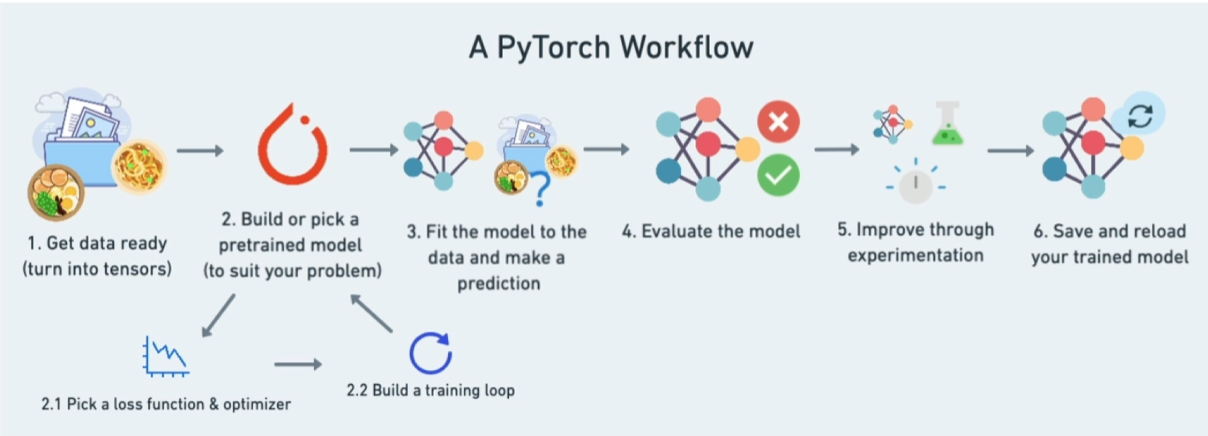

* Data - prepare and load
* Build the model
* Fitting the model to data (training)
* Make predictions and evaluate a model (inference)
* Saving and loading a model
* Putting it together

In [1]:
import torch
from torch import nn # pytorch neural network building blocks, the layer
import matplotlib.pyplot as plt
import numpy as np

# Saving pytorch models
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # pt or pth extension
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH)

# Random seed number
RANDOM_SEED = 42

# Check for cuda
device = "cpu" if torch.cuda.is_available() else "cpu"
print({device})

# Check pytorch verison
print({torch.__version__})

models\01_pytorch_workflow_model_0.pth
{'cpu'}
{'2.5.0+cu124'}


### Data - Preparing and loading

Anything that can be numerically represented = data in PyTorch/ML

ML = get data into numerical representation and build a model to learn its patterns

Test by creating a stright line of data via the linear regression formula

The goal of ML is to learn relationship between X and y values, learn a representation of the input and how it maps to the output.

In [2]:
# Create known params
weight = 0.7
bias = 0.3

# Create testing data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # Create a range of data
y = weight * X + bias # Linear Regression formula

print({X[:5]})
print({y[:5]})

{tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])}
{tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])}


### Split Data into training and test sets

This is probably the most important step as it allows you to train and evaluate

* Course = Training Set 60-80% of data
* Practice Exam = Validation Set 10-20% of data
* Final Exam = Test Set 10-20% of data

In [3]:
# Create a train/test split
train_split = int(0.8 * len(X)) # grab 80% of data samples
X_train, y_train = X[:train_split], y[:train_split] # Training data and labels
X_test, y_test = X[train_split:], y[train_split:] # Test data and labels

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

One of the biggest hurdles in ML will be properly creating Training and Test datasets and splits.

### Visualize the data

In [4]:
# Create a function with matplotlib to visualize the data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    # Plots training data, test data and compares
    plt.figure(figsize=(10,7)) # Width, height in inches.

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14});


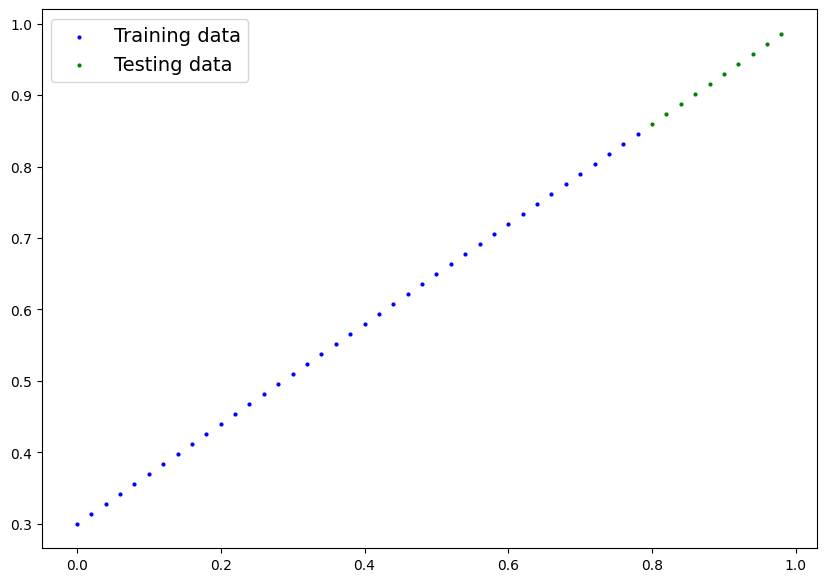

In [5]:
# Generate the graph
plot_predictions()

### Build a model

* Start with random numbers
* Look at the data
* Update random number to represent the pattern detected

In [6]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # Inherits from nn.Module
    def __init__(self):
        super().__init__()
        # Initialize Model Parameters
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        # Forward method to define the computation
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
        return self.weights * x + self.bias # Linear Regr formula


### Pytorch Model Building Essentials

* torch.nn - contains all the building blocks for computations graphs (neural network)
* torch.nn.Parameters - what parameters the model should try to learn, a layer from torch.nn will set these for us in most cases
* torch.nn.Module - base class for all neural network modules, when sub classed you need to create your own forward() method
* torch.optim - torch optimizer, adjust the values via algorithm
* def forward() - nn.Module subclasses require you to overwrite forward(), this performs computation on forward propagation

### Check the contents of our PyTorch model

* We can look at what is inside the model by using .parameters()

In [7]:
# Create a random seed
torch.manual_seed(RANDOM_SEED)

# Create an instance of our model
model_0 = LinearRegressionModel()

print({model_0.parameters()})
list(model_0.parameters())

{<generator object Module.parameters at 0x000001DAAFAD7990>}


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Make predictions with `torch.inference(mode)`

* How well it predicts y_test based on X_test

In [9]:
# Make predictions with model
# This is a context manager
# No gradient function, no tracking since we are not training
with torch.inference_mode():
    y_preds = model_0(X_test)

print({y_preds})

{tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])}


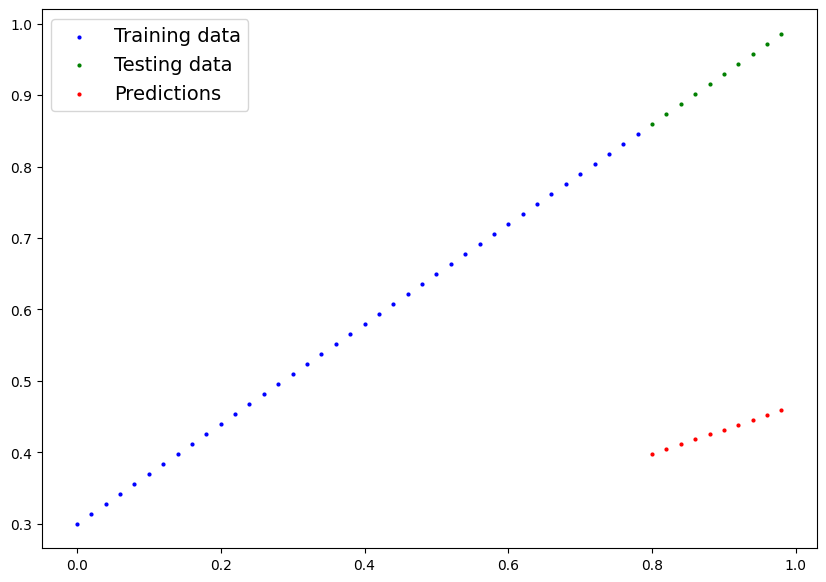

In [10]:
plot_predictions(predictions=y_preds)

### Train the Model

* Move from unknown or random parameters to some known parameters
* Get more accurate
* We need a Loss Function
* * Maybe called criterion or cost function
  * Used to measure how wrong the models predictions are to the ideal outputs
* We need an Optimizer
* * Account for loss and adjust the models parameters (weights and bias)
 
### We then need a Training and Testing Loop

In [11]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Be aware there are differnet **Loss Functions** and **Optimizers** for different needs and data.

In [13]:
# Setup loss function, HOW WRONG THE MODEL IS
loss_fn = nn.L1Loss()

# Setup Optimizer, HOW IT ADJUST TO BECOME ACCURATE
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001) # LR = learning rate hyperparameters

### Build a training and testing loop

* Training Loop
* * 1. Loop through the data
    2. Forward pass via forward()
    3. Calculate the loss
    4. Optimizer zero gradient
    5. Loss backward, back propagation
    6. Optimizer step - gradient descent


### X_train = training features
### y_train = training labels
### X_test = test features
### y_test = test labels
### loss = training loss
### pred = training predictions
### test_loss = training loss
### test_pred = training predictions

In [14]:
# Create a random seed
torch.manual_seed(RANDOM_SEED)

# Set number of Epochs
epochs = 2000

# Track values
epoch_count = []
loss_values = []
test_loss_values = []

# Training
# Loop through the data
for epoch in range(epochs):
    # Set the model training mode
    model_0.train() # Turns on gradient tracking

    # Forward pass
    y_pred = model_0(X_train) # pass in the training data

    # Calc the loss
    loss = loss_fn(y_pred, y_train) # check the diff between the pred and the train labels

    # Optimizer
    optimizer.zero_grad() # zero before each next optimizer step

    # Backprop on the loss in respect to the params of the model
    loss.backward()

    # Step the optimizer
    optimizer.step()

    # Testing
    model_0.eval() # Turns off different features not needed for testing
    with torch.inference_mode(): # Turns off gradient tracking
        
        # Forward pass
        test_pred = model_0(X_test) # Pass in the test features

        # Calc the test loss between test pred and test labels
        test_loss = loss_fn(test_pred, y_test)

    # Print out testing data
    if epoch % (epochs / 10) == 0:
        print(f"TEST - Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        print(f"TRAIN - {model_0.state_dict()}")

        # Update tracking variables
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss_values)

    # Print out training data
    #if epoch % (epochs / 10) == 0:
    #    print(epoch, model_0.state_dict())

TEST - Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.4931890368461609
TRAIN - OrderedDict([('weights', tensor([0.3371])), ('bias', tensor([0.1298]))])
TEST - Epoch: 200 | Loss: 0.08973254263401031 | Test Loss: 0.22795839607715607
TRAIN - OrderedDict([('weights', tensor([0.4150])), ('bias', tensor([0.3257]))])
TEST - Epoch: 400 | Loss: 0.04549176245927811 | Test Loss: 0.11657620966434479
TRAIN - OrderedDict([('weights', tensor([0.4730])), ('bias', tensor([0.3855]))])
TEST - Epoch: 600 | Loss: 0.03811401128768921 | Test Loss: 0.08986451476812363
TRAIN - OrderedDict([('weights', tensor([0.5104])), ('bias', tensor([0.3789]))])
TEST - Epoch: 800 | Loss: 0.03122851625084877 | Test Loss: 0.07297395914793015
TRAIN - OrderedDict([('weights', tensor([0.5448])), ('bias', tensor([0.3652]))])
TEST - Epoch: 1000 | Loss: 0.02435956709086895 | Test Loss: 0.05690721794962883
TRAIN - OrderedDict([('weights', tensor([0.5790])), ('bias', tensor([0.3508]))])
TEST - Epoch: 1200 | Loss: 0.0174906291067

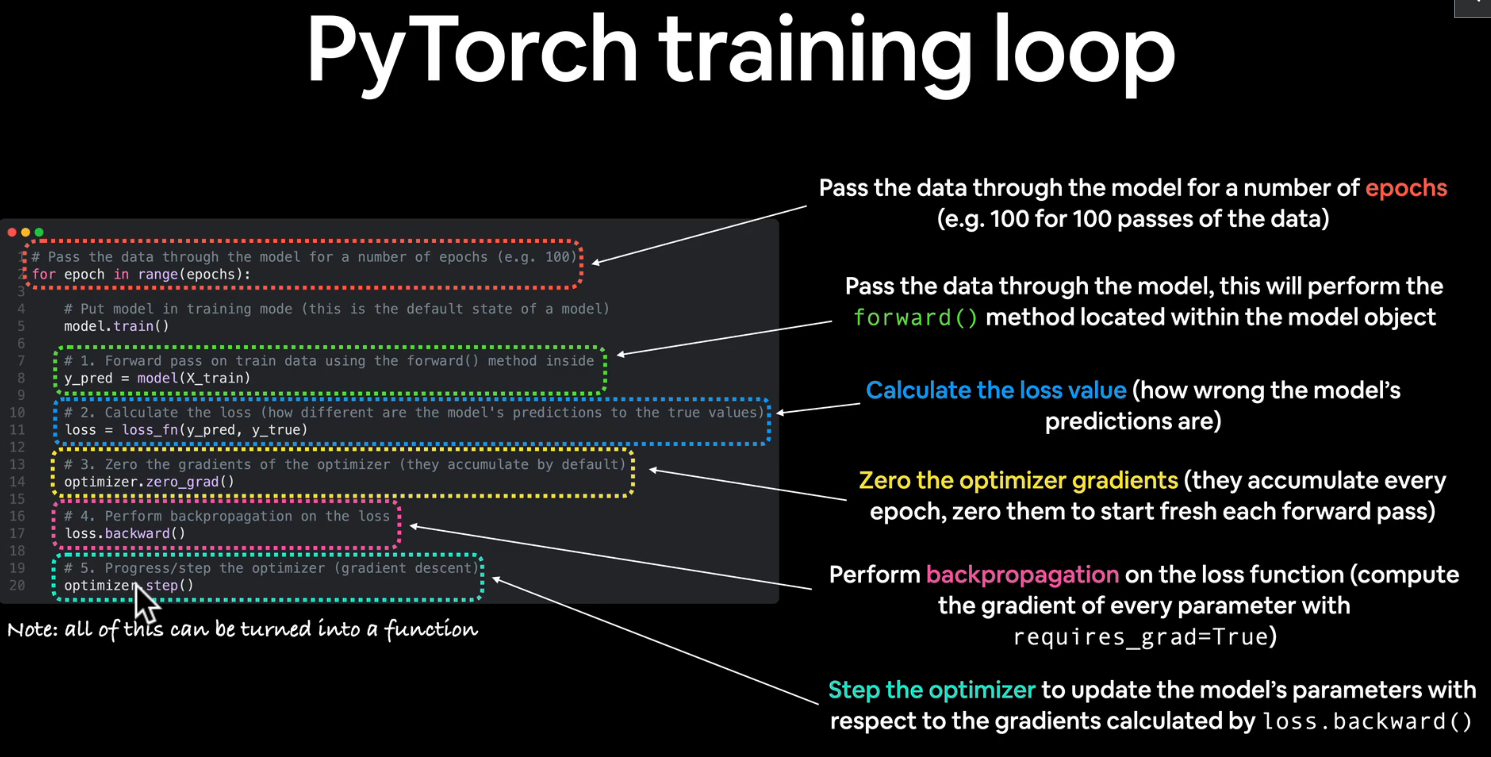

In [15]:
# For some reason this plt.plot is not working, copied and tested

'''
import matplotlib.pyplot as plt
import numpy as np

# Plot the loss curve, we will need to convert tensor values to numpy on cpu
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();
'''


'\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Plot the loss curve, we will need to convert tensor values to numpy on cpu\nplt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")\nplt.plot(epoch_count, test_loss_values, label="Test loss")\nplt.title("Training and test loss curve")\nplt.ylabel("Loss")\nplt.xlabel("Epochs")\nplt.legend();\n'

In [16]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [17]:
print({weight, bias}) # actual
model_0.state_dict() # trained

{0.7, 0.3}


OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])

### Original Predictions

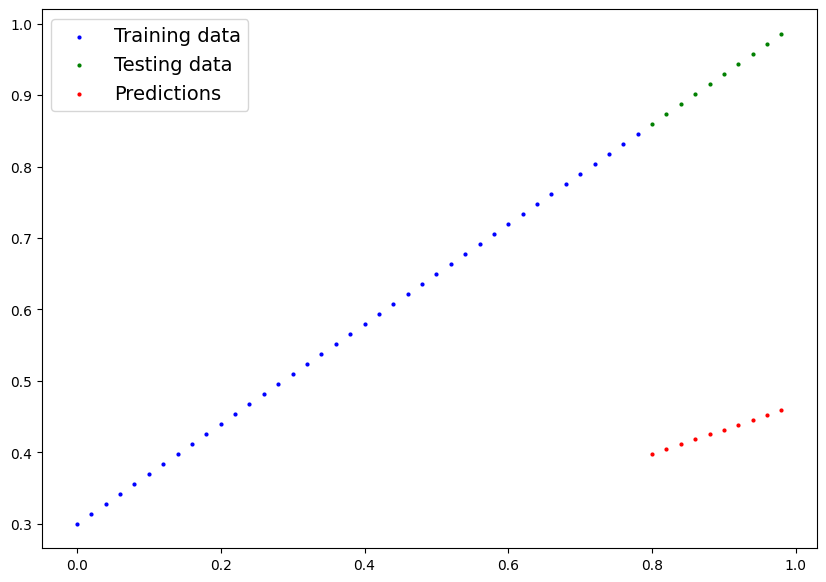

In [18]:
plot_predictions(predictions=y_preds);

### Trained Model Predictions

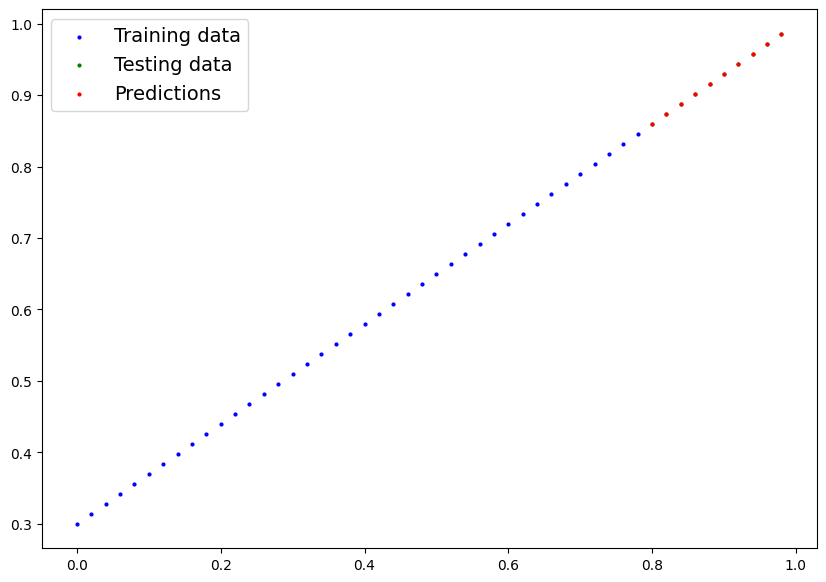

In [19]:
plot_predictions(predictions=y_preds_new);

### Model Flow

1. Send data to the model
2. Run the training portion of the loop
3. Run the testing portion of the loop

### Saving and loading models

1. `torch.save()` - Saves in Python pickle format
2. `torch.load()` - Loads in Python pickle format
3. `torch.nn.Module.load_state_dict()` - Allows you to load models saved state dict


In [20]:
# Save the model, most important code is up at the top
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)


Saving the model: models\01_pytorch_workflow_model_0.pth


In [23]:
!dir models

 Volume in drive C has no label.
 Volume Serial Number is D091-1A84

 Directory of C:\Users\user\Documents\GitHub\public\pytorch\Udemy-Pytorch-Class\Course Content\models

11/01/2024  12:15 AM    <DIR>          .
11/01/2024  12:16 AM    <DIR>          ..
11/01/2024  12:15 AM    <DIR>          .ipynb_checkpoints
11/01/2024  12:15 AM             1,680 01_pytorch_workflow_model_0.pth
               1 File(s)          1,680 bytes
               3 Dir(s)  3,565,866,385,408 bytes free


### Load in a saved model

In [25]:
# Instantiate a new model class
loaded_model_0 = LinearRegressionModel() # our model class

# Load the models state dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

C:\Users\user\AppData\Local\Temp\ipykernel_36556\561642975.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [27]:
# Check the loaded file state dict compared to model_0
print(model_0.state_dict())
print(loaded_model_0.state_dict())
# or
print(model_0.state_dict() == loaded_model_0.state_dict())

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])
OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])
True


In [30]:
# Compare predictions as well for both the loaded model preds and exiting preds
loaded_model_0.eval() # turn on eval mode
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

model_0.eval() # turn on eval mode
with torch.inference_mode():
    y_preds = model_0(X_test)

# Comparison
print(loaded_model_preds == y_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])
